<a href="https://colab.research.google.com/github/gulabpatel/simpletransformers/blob/main/SimpleTransformers_1_CoLA_Sentence_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Transformers - CoLA Sentence Classification


This Notebook is a port of the original "Fine-Tuning BERT for Sentence Classification" tutorial that Nick and I published in 2019 ([blog post](http://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Notebook](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX)) to use the `Simple Transformers` library.

This version has less comments and explanation than my typical Notebooks--the goal was just to get a quick sense of the `Simple Transformers` library.



# Contents

See "Table of contents" in the sidebar to the left.

# S1. Setup

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing Simple Transformers



* Install Simple Transformers
* Seeing some disconcerting errors...

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 17.7MB/s 
     |████████████████████████████████| 2.9MB 52.2MB/s 
     |████████████████████████████████| 1.3MB 43.8MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 1.7MB 44.0MB/s 
     |████████████████████████████████| 7.4MB 43.2MB/s 
     |████████████████████████████████| 317kB 51.6MB/s 
     |████████████████████████████████| 890kB 44.8MB/s 
     |████████████████████████████████| 1.1MB 45.7MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 163kB 49.3MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 122kB 49.9MB/s 
     |████████████████████████████████| 112kB 51.1MB/s 
     |████████████████████████████████| 6.7MB 41.7MB/s 
     |████████████████████████████████| 133kB 51.9MB/s 
     |████████████████████████████████| 4.4MB 43.6MB

# S2. Loading CoLA Dataset


We'll use [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.


## 2.1. Download & Extract

We'll use the `wget` package to download the dataset to the Colab instance's file system. 

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=b003a730be99ec7480f5104b60146f4b3ecd59bbc824910f5a2a456b29d53ec9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


The dataset is hosted on GitHub in this repo: https://nyu-mll.github.io/CoLA/

In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Unzip the dataset to the file system. You can browse the file system of the Colab instance in the sidebar on the left.

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
5740,c_13,1,NaN,Juliet says that Romeo lies to his parents a lot.
6294,c_13,1,NaN,To be able to buy myself a ticket to France wo...
2750,l-93,1,NaN,Carmen obtained a spare part from Diana.
5521,b_73,1,NaN,John wants to come up with as good a solution ...
7098,sgww85,1,NaN,"John left his office at 11 and at 12, the libr..."
6930,m_02,1,NaN,Helen sent a scarf to Jim for Margaret.
4506,ks08,1,NaN,"Mary sang a song, but Lee never did."
4451,ks08,1,NaN,In no other circumstances does that distinctio...
7895,ad03,1,NaN,The Emperor's every wish was immediately carri...
7299,sks13,1,NaN,Pelé visited his uncle.


The two properties we actually care about are the the `sentence` and its `label`, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).

## 2.3. Prep Data for SimpleTransformers

Logging setup - Makes the `transformers` logger less verbose.

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

# Get root logger (all other loggers will be derived from this logger's
# properties)
logger = logging.getLogger()
logger.warning("Is this working?") 

# Get the logger for the huggingface/transformers library.
transformers_logger = logging.getLogger("transformers")

# Set the logging level to warning, meaning display warnings and worse, but 
# don't display any `INFO` logs.
transformers_logger.setLevel(logging.WARNING)

Convert the dataset into a simple list of [text, label] pairs.

I'm following this code snippet from the documentation as my reference:
```python
# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns. If the Dataframe has a header, it should contain a 'text' and a 'labels' column. If no header is present, the Dataframe should contain at least two columns, with the first column is the text with type str, and the second column in the label with type int.
train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0], ['Example eval senntence belonging to class 2', 2]]
train_df = pd.DataFrame(train_data)

eval_data = [['Example eval sentence belonging to class 1', 1], ['Example eval sentence belonging to class 0', 0], ['Example eval senntence belonging to class 2', 2]]
eval_df = pd.DataFrame(eval_data)

```

In [ ]:
# Select just the text and its label.
df = df[['sentence', 'label']]

# Rename 'sentence' column to 'text' (this is the name SimpleTransformers 
# expects).
df.columns = ['text', 'label']

Split off 10% for validation.

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_df, validation_df = train_test_split(df, random_state=2018, test_size=0.1)

In [ ]:
len(train_df)

7695

In [ ]:
len(validation_df)

856

**Test Set**

**TODO** - The .tsv file doesn't include headers, so I've specified them here. This means that I can directly name the 'sentence' column 'text', but I think it's more illustrative this way?

In [ ]:
# Load the dataset into a pandas dataframe.
df_test = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Select just the text and its label.
df_test = df_test[['sentence', 'label']]

# Rename 'sentence' column to 'text' (this is the name SimpleTransformers 
# expects).
df_test.columns = ['text', 'label']


Number of test sentences: 8,551



# S3. Fine-Tuning

## 3.1. Load Pre-Trained Model

What's this reprocess_input_data argument?

Documentation for arguments is [here](https://github.com/ThilinaRajapakse/simpletransformers#default-settings).

> reprocess_input_data: bool
If True, the input data will be reprocessed even if a cached file of the input data exists in the cache_dir.

In [ ]:
from simpletransformers.classification import ClassificationModel

args = {
    'reprocess_input_data': True, 
    'overwrite_output_dir': True
}

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=2, args=args)

# You can set class weights by using the optional weight argument


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
INFO:filelock:Lock 139956352702728 acquired on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock


INFO:filelock:Lock 139956352702728 released on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
INFO:filelock:Lock 139956302413216 acquired on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock


INFO:filelock:Lock 139956302413216 released on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

INFO:filelock:Lock 139960397168200 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock


## 3.2. Inspect Training Arguments

All of the cool features we're interested in are managed through this `model.args` object. 

In [ ]:
type(model.args)

simpletransformers.config.model_args.ClassificationArgs

The following cell retrieves all of the arguments and their values, and prints them in a table.

There is also some brief documentation on them [here](https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model).

In [ ]:
arg_values = []

pd.set_option('display.max_rows', 80)

# For all of the arguments...
for arg in dir(model.args):
    
    # Skip over the special attributes and any functions.
    if (not arg[0:2] == '__') and (not callable(getattr(model.args, arg))):
    
        # Store the argument and its value as a tuple.
        arg_values.append((arg, str(getattr(model.args, arg))))

# Store as a dataframe just to get the pretty printout.
df_args = pd.DataFrame(arg_values)        

df_args

,0,1
0,adam_epsilon,1e-08
1,best_model_dir,outputs/best_model
2,cache_dir,cache_dir/
3,config,{}
4,custom_layer_parameters,[]
5,custom_parameter_groups,[]
6,dataloader_num_workers,1
7,do_lower_case,False
8,dynamic_quantize,False
9,early_stopping_consider_epochs,False


### Noteworthy Args

Below are what I'd consider the most critical arguments--they'll have the most immediate impact on your accuracy.

What's displayed are their default values (except model-name, which we specified earlier).

In [ ]:
model.args.train_batch_size

8

In [ ]:
model.args.num_train_epochs

1

In [ ]:
model.args.max_seq_length

128

In [ ]:
model.args.learning_rate

4e-05

In [ ]:
model.args.model_name

'bert-base-uncased'

## 3.3. Run Training

#### Choose Hyperparameters

In [ ]:
# These are the values we used in our Notebook:
model.args.max_seq_length = 128
model.args.num_train_epochs = 4
model.args.train_batch_size = 32
model.args.learning_rate = 2e-5

#### Configure Validation

Periodically evaluate on our 10% validation set during training to monitor over-fitting.

Calculate number of steps so we can specify how often to evaluate.

In [ ]:
import numpy as np

# Num steps in epoch = num training samples / batch size
steps_per_epoch = int(np.ceil(len(train_df) / float(model.args.train_batch_size)))

print('Each epoch will have {:,} steps.'.format(steps_per_epoch))

Each epoch will have 241 steps.


Turn on validation.

In [ ]:
# Run evaluation periodically during training to monitor progress.
model.args.evaluate_during_training = True

# "Print results from evaluation during training."
model.args.evaluate_during_training_verbose = True

# "Perform evaluation at every specified number of steps. A checkpoint model and
#  the evaluation results will be saved."
model.args.evaluate_during_training_steps = 120

# We only need to tokenize our validation set once, then we can read it from the
# cache.
model.args.use_cached_eval_features = True

#### Configure Early Stopping

There's a nice intro to early stopping in their docs here:
    
* https://simpletransformers.ai/docs/usage/#using-early-stopping



In [ ]:
# Turn on early stopping.
model.args.use_early_stopping = True

# "The improvement over best_eval_loss necessary to count as a better checkpoint."
model.args.early_stopping_delta = 0.01

# What metric to use in calculating score for evaluation set (plus whether a low
# vs. high value is better for this metric).

#model.args.early_stopping_metric = "mcc"
#model.args.early_stopping_metric_minimize = False

model.args.early_stopping_metric = "eval_loss"
model.args.early_stopping_metric_minimize = True

# "Terminate training after this many evaluations without an improvement in the
#  evaluation metric greater then early_stopping_delta."
model.args.early_stopping_patience = 2


#### Kick-Off Training

The log statements aren't easy to interpret, but you can infer that it's running validation twice per epoch. 

There are also some statements related to early stopping, and if you look at the validation loss at each checkpoint, you can make sense of the early stopping behavior.

I'm hoping/assuming that `wandb` integration will make this much easier to look at!

In [ ]:
print('Training on {:,} samples...'.format(len(train_df)))

# Train the model, testing against the validation set periodically.
out = model.train_model(train_df, eval_df=validation_df)

Training on 7,695 samples...


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:353: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:851: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36509899446693134, 'tp': 520, 'tn': 119, 'fp': 145, 'fn': 72, 'eval_loss': 0.5319398908971626}
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the sch

INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4580448418199385, 'tp': 544, 'tn': 127, 'fp': 137, 'fn': 48, 'eval_loss': 0.4789898394145698}


INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5171962761082096, 'tp': 556, 'tn': 134, 'fp': 130, 'fn': 36, 'eval_loss': 0.5009610512964079}
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 2
INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5494103862626102, 'tp': 532, 'tn': 165, 'fp': 99, 'fn': 60, 'eval_loss': 0.4554820476430599}


INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5564186736070834, 'tp': 531, 'tn': 168, 'fp': 96, 'fn': 61, 'eval_loss': 0.45477539342697537}


INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5012425098989287, 'tp': 554, 'tn': 131, 'fp': 133, 'fn': 38, 'eval_loss': 0.5868310144292974}
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 2
INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5142091569607425, 'tp': 527, 'tn': 158, 'fp': 106, 'fn': 65, 'eval_loss': 0.5482129334933429}
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 

INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5380886039281899, 'tp': 521, 'tn': 170, 'fp': 94, 'fn': 71, 'eval_loss': 0.5416202939019721}


INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.53437158532515, 'tp': 542, 'tn': 152, 'fp': 112, 'fn': 50, 'eval_loss': 0.585158633573033}
INFO:simpletransformers.classification.classification_model: Patience of 2 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.


INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


## 3.4. Inspect generated files

Helper function to print the contents of a directory, with file sizes in MB.

In [ ]:
import os 
import pandas as pd

def list_files_info(data_dir):
    '''
    Prints out the files in a directory along with their sizes in MB.
    '''

    # Check out the sizes on the saved files.
    files = list(os.listdir(data_dir))

    print(data_dir)

    rows = []

    # For each file in the directory...
    for f in files:
        # Get the file size, in MB
        f_size = float(os.stat(data_dir + '/' + f).st_size) / 2**20
        
        # Print the filename and its size.
        print("     {:25s}    {:>8.2f} MB".format(f, f_size))

        rows.append([f, '{:.2f} MB'.format(f_size)])

    print('')

    return pd.DataFrame(rows, columns=['File', 'Size'])


This cache folder stores the tokenized and encoded text data.

In [ ]:
list_files_info('./cache_dir')

./cache_dir
     cached_dev_bert_128_2_856        0.68 MB
     cached_train_bert_128_2_7695        6.07 MB



,File,Size
0,cached_dev_bert_128_2_856,0.68 MB
1,cached_train_bert_128_2_7695,6.07 MB


The `outputs` folder contains the final model, plus all of the checkpoints.

In [ ]:
list_files_info('./outputs/')

./outputs/
     vocab.txt                        0.22 MB
     checkpoint-120                   0.00 MB
     checkpoint-482-epoch-2           0.00 MB
     checkpoint-720                   0.00 MB
     checkpoint-241-epoch-1           0.00 MB
     checkpoint-840                   0.00 MB
     special_tokens_map.json          0.00 MB
     tokenizer_config.json            0.00 MB
     checkpoint-360                   0.00 MB
     checkpoint-480                   0.00 MB
     eval_results.txt                 0.00 MB
     model_args.json                  0.00 MB
     checkpoint-723-epoch-3           0.00 MB
     checkpoint-240                   0.00 MB
     best_model                       0.00 MB
     training_args.bin                0.00 MB
     config.json                      0.00 MB
     pytorch_model.bin              417.73 MB
     checkpoint-600                   0.00 MB
     training_progress_scores.csv        0.00 MB



,File,Size
0,vocab.txt,0.22 MB
1,checkpoint-120,0.00 MB
2,checkpoint-482-epoch-2,0.00 MB
3,checkpoint-720,0.00 MB
4,checkpoint-241-epoch-1,0.00 MB
5,checkpoint-840,0.00 MB
6,special_tokens_map.json,0.00 MB
7,tokenizer_config.json,0.00 MB
8,checkpoint-360,0.00 MB
9,checkpoint-480,0.00 MB


## 3.5. Evaluate on Test Set


Let's load the model from the checkpoint which performed best on the validation set. 

This is how we combat overfitting--the "final" model (at the end of all training epochs) will perform best on the training set, but may not generalize as well to new data. 

So, instead, we use an earlier checkpoint where the training loss was higher but the validation loss was at its lowest! 

In [ ]:
model = ClassificationModel(
    "bert", "outputs/best_model"
)

**On Validation Set**

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(validation_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:851: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856


INFO:simpletransformers.classification.classification_model:{'mcc': 0.5494103862626102, 'tp': 532, 'tn': 165, 'fp': 99, 'fn': 60, 'eval_loss': 0.4554820476430599}


In [ ]:
print(result)

{'mcc': 0.5494103862626102, 'tp': 532, 'tn': 165, 'fp': 99, 'fn': 60, 'eval_loss': 0.4554820476430599}


**On Test Set**

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_test)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:851: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.4533677632398824, 'tp': 323, 'tn': 79, 'fp': 83, 'fn': 31, 'eval_loss': 0.5259761724907618}


Without SimpleTransformers, original score: `Total MCC: 0.498`

In [ ]:
print('MCC: %.3f' % result['mcc'])

MCC: 0.453


**Run on New Text**

In [ ]:
predictions, raw_outputs = model.predict(["Some arbitary sentence"])

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


# S4. Conclusion

## 4.1. Observations


**Less Code, More Documentation**

* No more:
    * Tokenization code
    * PyTorch taining loop code

* Instead --> Careful argument selection!



**Colab Compatibility**

* Alarming install errors, but no problems yet...


**Checkpoints**

* Automatically saves checkpoints!
* Loading back a model from a checkpoint is trivial!



**Early Stopping**

* Harder than it sounds:
    * You must specify:
        * eval frequency
        * minimum "delta"        
        * "patience"

* Didn't immediately improve our CoLA score...
     * But we're not done exploring the technique yet!



## 4.2. Next Steps

**Weights & Biases - "wandb"**

* Set this up and try it out!
    * Does it plot the learning curve for us?



**Make Early Stopping Work**

* Is it easier to apply to a different dataset?
* Was the final model better than the "best model"?



**Resume Training from Checkpoint**

* Checkpoints should allow us to resume training in case we get disconnected from Colab...
    * How do you resume?
    * Save our checkpoints to GDrive (otherwise they'll be lost!)

# A.1. Over-Fitting from Original Notebook

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
#df_stats = pd.DataFrame(data=training_stats)
df_stats = pd.read_csv("/content/outputs/training_progress_scores.csv")
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('global_step')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,tp,tn,fp,fn,mcc,train_loss,eval_loss
global_step,,,,,,,
120,520,119,145,72,0.37,0.59,0.53
240,548,116,148,44,0.43,0.59,0.48
241,544,127,137,48,0.46,0.61,0.48
360,556,134,130,36,0.52,0.26,0.50
480,532,165,99,60,0.55,0.49,0.46
482,531,168,96,61,0.56,0.21,0.45
600,554,131,133,38,0.50,0.22,0.59
720,527,158,106,65,0.51,0.19,0.55
723,521,170,94,71,0.54,0.04,0.54


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

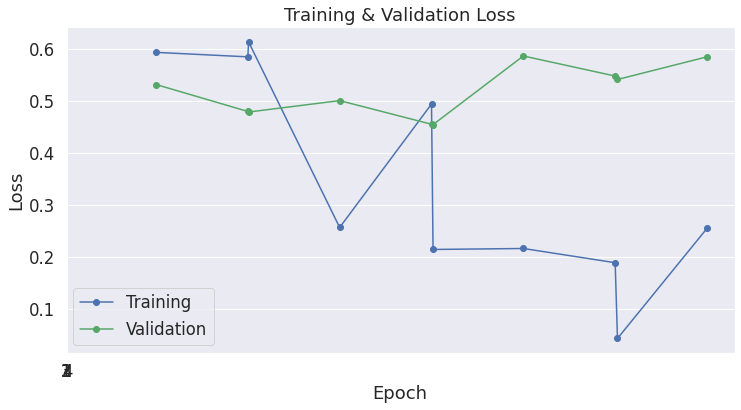

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['train_loss'], 'b-o', label="Training")
plt.plot(df_stats['eval_loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()